<a href="https://colab.research.google.com/github/skytecat/CreditScoring/blob/main/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка библиотек

In [1]:
# Установка необходимых библиотек
!pip install catboost
# !pip install optuna

# Импорт библиотек
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


## Загрузка данных

In [12]:
# Загрузка данных
full_data = pd.read_csv("/content/drive/MyDrive/SHIFT_ML_2025_COMPETITION/shift_ml_2025_train.csv")

# Разделение на признаки и целевую переменную
X = full_data.drop(['итоговый_статус_займа'], axis=1)
y = full_data['итоговый_статус_займа']

/tmp/ipython-input-806522538.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv("/content/drive/MyDrive/SHIFT_ML_2025_COMPETITION/shift_ml_2025_train.csv")


## Первичный анализ

In [13]:
X.head(5)

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,...,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,...,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,...,50.0,0.0,0.0,10920900.0,934800.0,310000.0,743850.0,NaN,Нет,Наличные
2,68426831,597500.0,3 года,13.44,20259.0,В,В3,ветеринарный техник,4 года,АРЕНДА,...,100.0,0.0,0.0,845000.0,639900.0,470000.0,200000.0,NaN,Нет,Наличные
3,68476668,1000000.0,3 года,9.17,31879.0,Б,Б2,вице-президент операций по набору персонала,10+ лет,ИПОТЕКА,...,100.0,0.0,0.0,19442600.0,5838100.0,1575000.0,2322600.0,NaN,Нет,Наличные
4,67275481,1000000.0,3 года,8.49,31563.0,Б,Б1,дорожному водителю,10+ лет,ИПОТЕКА,...,0.0,0.0,0.0,9669500.0,1396850.0,725000.0,1807200.0,NaN,Нет,Наличные


In [14]:
# Столбцы в train
X.columns.to_list()

['id',
 'сумма_займа',
 'срок_займа',
 'процентная_ставка',
 'аннуитет',
 'рейтинг',
 'допрейтинг',
 'профессия_заемщика',
 'стаж',
 'владение_жильем',
 'годовой_доход',
 'подтвержден_ли_доход',
 'рейтинг_OCR',
 'платежный_график',
 'коэфф_акционных_зачислений_в_остатке',
 'цель_займа',
 'кол_во_субсидий_за_год',
 'индекс_проживания',
 'регион',
 'пдн',
 'пос_стоп_фактор',
 'юридический_статус',
 'кол-во_просрочек_за_два_года',
 'коэфф_невыплаченного_сумм_остатка',
 'коэфф_исходного_платежа',
 'дата_первого_займа',
 'нижний_порог_рейтинга_заемщика',
 'верхний_порог_рейтинга_заемщика',
 'кол-во_заявок_за_полгода',
 'кол-во_месяцев_с_последней_просрочки',
 'кол-во_месяцев_с_последнего_займа',
 'кол-во_открытых_счетов',
 'кол-во_записей_в_общедоступных_документах',
 'оборотный_баланс',
 'коэфф_загрузки_возобновляемого_счета',
 'кол-во_счетов',
 'первоначальный_статус_займа',
 'непогашенная_сумма_из_тела_займов',
 'сумма_выплат_по_просрочкам',
 'пени_за_дефолт',
 'дата_следующей_выплаты',


Признак **пени_за_дефолт** вызывает подозрение на утечку данных (**data leakage**).


Этот признак становится известен только после наступления события "дефолт", то есть использовать его для предсказания этого события - это нарушение причинно-следственной связи. Модель не должна знать "будущее". Его необходимо удалить из признаков, используемых для обучения модели

Также следует удалить признак **дата_следующей_выплаты**, так как он является потенциальной утечкой данных. Дата следующей выплаты содержит информацию о будущем поведении заемщика, что нарушает причинно-следственную связь в предсказательной модели

In [15]:
X = X.drop(['пени_за_дефолт', 'дата_следующей_выплаты'], axis=1)

In [16]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% данных для теста
    stratify=y,     # сохраняем пропорции классов
    random_state=42 # для воспроизводимости результатов
)

In [17]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение целевой переменной в тренировочных данных:")
print(round(y_train.value_counts(normalize=True),2))
print(f"\nРаспределение целевой переменной в тестовых данных:")
print(round(y_test.value_counts(normalize=True),2))

Размер тренировочной выборки: (968623, 106)
Размер тестовой выборки: (242156, 106)

Распределение целевой переменной в тренировочных данных:
итоговый_статус_займа
0    0.8
1    0.2
Name: proportion, dtype: float64

Распределение целевой переменной в тестовых данных:
итоговый_статус_займа
0    0.8
1    0.2
Name: proportion, dtype: float64


In [18]:
# Проверка на пересечение ID в тестовой и тренировочной выборке
overlap = len(set(X_train['id']) & set(X_test['id']))
print(f"Количество совпадающих ID: {overlap}")

Количество совпадающих ID: 0


Вывод: Количество совпадающих id между обучающей и тестовой выборками - 0. Это означает, что выборки независимы по идентификаторам заемщиков.


**Признак id необходимо удалить** из признаков, используемых для обучения модели, т.к. он не несет никакой информации о характеристиках заемщика, его поведении или рисках. Модель, обученная на старых id, не сможет использовать этот признак для предсказания. Это может привести к переобучению модели


In [19]:
X_train, X_test = X_train.drop('id', axis=1), X_test.drop('id', axis=1)

In [20]:
# Анализ типов данных признаков
print(X.dtypes.value_counts())

float64    83
object     18
int64       5
Name: count, dtype: int64


## Выбор метрики оценки качества модели
В задаче кредитного скоринга выбор правильной метрики критически важен для
обеспечения соответствия бизнес-целям и корректной оценки модели.
Общепринятой метрикой в такой задаче является ROC AUC


In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Давайте еще раз посмотрим распределение целевой переменной
print("Распределение целевой переменной:")
target_distribution = y.value_counts(normalize=True)
print(target_distribution)

# Объяснение выбора ROC AUC
print("""
=== Почему выбрана метрика ROC AUC? ===

1. ФОКУС НА РАНЖИРОВАНИИ:
   - Нам важнее правильно упорядочить клиентов по уровню риска
   - ROC AUC измеряет способность модели отделять классы, а не точные вероятности

2. УСТОЙЧИВОСТЬ К ДИСБАЛАНСУ:
   - Дефолтных клиентов ~{:.1%}, надежных ~{:.1%}
   - ROC AUC не зависит от порога классификации
   - Accuracy в данном случае обманчива (даже случайная модель даст ~{:.1%} accuracy)

3. БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
   - AUC = 0.8 означает: вероятность 80%, что модель
     правильно ранжирует случайную пару (дефолтный, надежный) клиент
   - Это напрямую связано с бизнес-целью: минимизировать кредитные потери
""".format(target_distribution[0], target_distribution[1], target_distribution[0]))

Распределение целевой переменной:
итоговый_статус_займа
0    0.800381
1    0.199619
Name: proportion, dtype: float64

=== Почему выбрана метрика ROC AUC? ===

1. ФОКУС НА РАНЖИРОВАНИИ:
   - Нам важнее правильно упорядочить клиентов по уровню риска
   - ROC AUC измеряет способность модели отделять классы, а не точные вероятности

2. УСТОЙЧИВОСТЬ К ДИСБАЛАНСУ:
   - Дефолтных клиентов ~80.0%, надежных ~20.0%
   - ROC AUC не зависит от порога классификации
   - Accuracy в данном случае обманчива (даже случайная модель даст ~80.0% accuracy)

3. БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
   - AUC = 0.8 означает: вероятность 80%, что модель 
     правильно ранжирует случайную пару (дефолтный, надежный) клиент
   - Это напрямую связано с бизнес-целью: минимизировать кредитные потери



=== Проблемы других метрик ===
Accuracy наивной модели: 0.8004
ROC AUC наивной модели: ~0.5000 (случайная модель)

Пример хорошей модели:
ROC AUC: 0.9600
Accuracy (при пороге 0.5): 0.8904
=== Визуализация ROC-кривых ===


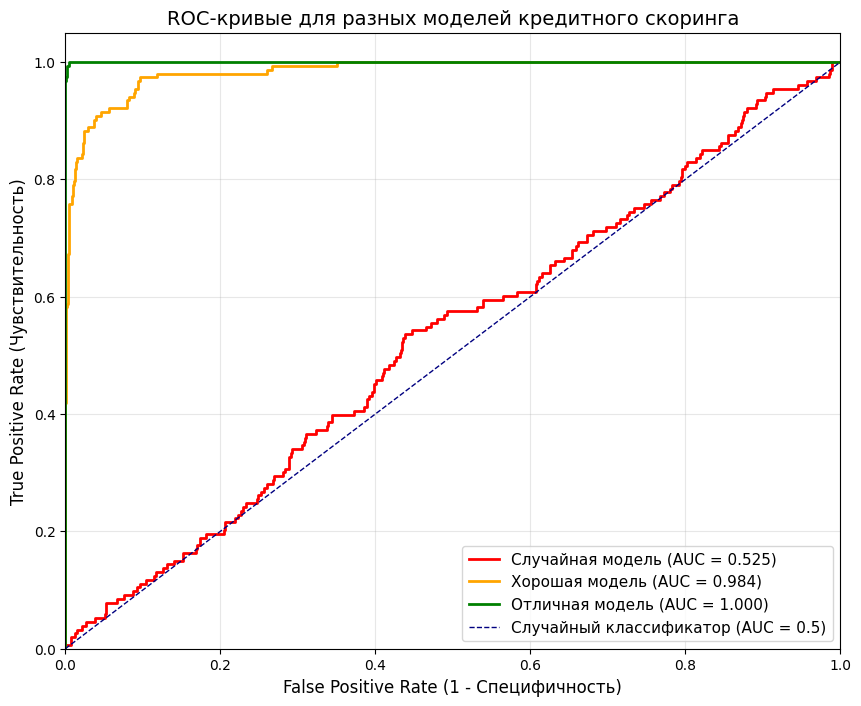

Результаты моделей:
Случайная модель: AUC = 0.525
Хорошая модель: AUC = 0.984
Отличная модель: AUC = 1.000

Accuracy при пороге 0.5:
Случайная модель: Accuracy = 0.507
Хорошая модель: Accuracy = 0.921
Отличная модель: Accuracy = 0.995
(Разница в accuracy кажется меньшей, чем разница в AUC)


In [33]:
# Демонстрация проблемы с другими метриками
print("=== Проблемы других метрик ===")

# Симуляция "наивной" модели, которая всегда предсказывает класс 0
y_true = y.values
y_naive_pred = np.zeros_like(y_true)  # Всегда предсказывает "надежный клиент"

print(f"Accuracy наивной модели: {accuracy_score(y_true, y_naive_pred):.4f}")
print(f"ROC AUC наивной модели: ~0.5000 (случайная модель)")

# Симуляция хорошей модели с AUC ~ 0.8
np.random.seed(42)
# Создаем "хорошие" предсказания, коррелирующие с истинными значениями
y_good_pred_proba = np.random.beta(2, 5, size=len(y_true))  # Асимметричное распределение
y_good_pred_proba[y_true == 1] = np.random.beta(5, 2, size=np.sum(y_true == 1))  # Для дефолтных клиентов

print(f"\nПример хорошей модели:")
print(f"ROC AUC: {roc_auc_score(y_true, y_good_pred_proba):.4f}")
print(f"Accuracy (при пороге 0.5): {accuracy_score(y_true, y_good_pred_proba > 0.5):.4f}")


# Визуализация ROC кривых
print("=== Визуализация ROC-кривых ===")

# Создаем синтетические данные для демонстрации
np.random.seed(42)
n_samples = 1000
y_test = np.random.binomial(1, 0.15, n_samples)  # 15% дефолтов

# Три модели для сравнения:
# 1. Случайная модель
y_pred_random = np.random.uniform(0, 1, n_samples)
fpr_random, tpr_random, _ = roc_curve(y_test, y_pred_random)
auc_random = auc(fpr_random, tpr_random)

# 2. Хорошая модель
y_pred_good = np.where(y_test == 1,
                       np.random.beta(4, 1, n_samples),  # Высокие вероятности для дефолтов
                       np.random.beta(1, 4, n_samples))  # Низкие вероятности для надежных
fpr_good, tpr_good, _ = roc_curve(y_test, y_pred_good)
auc_good = auc(fpr_good, tpr_good)

# 3. Отличная модель
y_pred_excellent = np.where(y_test == 1,
                           np.random.beta(8, 1, n_samples),  # Очень высокие вероятности для дефолтов
                           np.random.beta(1, 8, n_samples))  # Очень низкие вероятности для надежных
fpr_excellent, tpr_excellent, _ = roc_curve(y_test, y_pred_excellent)
auc_excellent = auc(fpr_excellent, tpr_excellent)

# Построение графика ROC-кривых
plt.figure(figsize=(10, 8))
plt.plot(fpr_random, tpr_random, color='red', lw=2, label=f'Случайная модель (AUC = {auc_random:.3f})')
plt.plot(fpr_good, tpr_good, color='orange', lw=2, label=f'Хорошая модель (AUC = {auc_good:.3f})')
plt.plot(fpr_excellent, tpr_excellent, color='green', lw=2, label=f'Отличная модель (AUC = {auc_excellent:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Случайный классификатор (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Специфичность)', fontsize=12)
plt.ylabel('True Positive Rate (Чувствительность)', fontsize=12)
plt.title('ROC-кривые для разных моделей кредитного скоринга', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Результаты моделей:")
print(f"Случайная модель: AUC = {auc_random:.3f}")
print(f"Хорошая модель: AUC = {auc_good:.3f}")
print(f"Отличная модель: AUC = {auc_excellent:.3f}")

# Показываем, почему accuracy может быть обманчивой
threshold = 0.5
accuracy_random = accuracy_score(y_test, y_pred_random > threshold)
accuracy_good = accuracy_score(y_test, y_pred_good > threshold)
accuracy_excellent = accuracy_score(y_test, y_pred_excellent > threshold)

print(f"\nAccuracy при пороге {threshold}:")
print(f"Случайная модель: Accuracy = {accuracy_random:.3f}")
print(f"Хорошая модель: Accuracy = {accuracy_good:.3f}")
print(f"Отличная модель: Accuracy = {accuracy_excellent:.3f}")
print("(Разница в accuracy кажется меньшей, чем разница в AUC)")


**Вывод**:

ROC AUC выбрана как основная метрика потому что:

*   Измеряет качество ранжирования рисков (главная цель кредитного скоринга)
*   Устойчива к дисбалансу классов
*   Имеет четкую бизнес-интерпретацию
*   Не зависит от выбора порога классификации
*   Стандарт в банковской индустрии

**Выбор модели:**

У нас есть 18 категориальных признаков. Обработка таких признаков требует особого подхода (например, One-Hot Encoding, Label Encoding). Многие алгоритмы (например, логистическая регрессия, SVM) не могут напрямую работать с текстовыми категориями.


**CatBoost** же разработан специально для эффективной и автоматической обработки категориальных данных. Его можно напрямую обучить на признаках типа object без необходимости предварительного ручного кодирования. Также он хорошо справляется с пропущенными значениями и не требует их обязательного заполнения средними/медианами.

Вывод: Наличие большого количества категориальных признаков (object) делает CatBoost идеальным кандидатом для этой задачи, обеспечивая при этом высокое качество, удобство использования и минимальную необходимость в ручной предобработке категорий.

## Baseline

In [ ]:
# Выберем только числовые признаки, чтобы избежать сложностей с кодированием категориальных переменных на этом этапе
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_num = X[num_features]

# Заполним пропуски медианой
X_num = X_num.fillna(X_num.median())

# Используем только часть данных для ускорения обучения
sample_size = min(10_000, len(X_num))
idx_sample = np.random.RandomState(42).choice(X_num.index, size=sample_size, replace=False)
X_sample = X_num.loc[idx_sample]
y_sample = y.loc[idx_sample]

# Разделение на train и validation с учетом дисбаланса
X_train, X_val, y_train, y_val = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    stratify=y_sample,
    random_state=42
)

# Нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Обучение модели
model = LogisticRegression(
    C=1.0,
    solver='liblinear',
    max_iter=100,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Оценка модели
val_pred = model.predict_proba(X_val_scaled)[:, 1]
auc_score = roc_auc_score(y_val, val_pred)
print(f"Logistic Regression AUC: {auc_score:.4f}")

Logistic Regression AUC: 0.7097


## Feature Engineering

Создаем **новые признаки** на основе существующих данных, чтобы предоставить модели дополнительную информацию и потенциально улучшить её предсказательную способность

In [ ]:
rating_rate = train_full.groupby('рейтинг')['итоговый_статус_займа'].mean()
X['платеж_на_доход'] = X['аннуитет'] / (X['годовой_доход'] / 12 + 1)
X['займ_на_доход'] = X['сумма_займа'] / (X['годовой_доход'] + 1)
X['отношение_просрочек'] = X['сумма_выплат_по_просрочкам'] / (X['сумма_займа'] + 1)
X['дефолт_по_рейтингу'] = X['рейтинг'].map(rating_rate).fillna(0)
X['доля_карт_без_нарушений'] = X['кол-во_карт_без_нарушений'] / (X['кол-во_карт'] + 1)
X['сумма_на_счетах_к_долгу'] = X['общая_сумма_на_счетах'] / (X['непогашенная_сумма_из_тела_займов'] + 1)
X['сумма_на_счетах_к_аннуитету'] = X['общая_сумма_на_счетах'] / (X['аннуитет'] + 1)
X['просрочка_к_доходу'] = X['сумма_выплат_по_просрочкам'] / (X['годовой_доход'] + 1)
X['баланс_к_аннуитету'] = X['оборотный_баланс'] / (X['аннуитет'] + 1)

**Созданные признаки:**

**платеж_на_доход:**
Отношение ежемесячного аннуитетного платежа к среднемесячному доходу заемщика. Показывает, какую долю своего дохода заемщик тратит на обслуживание этого займа.

**займ_на_доход**:
Отношение общей суммы займа к годовому доходу. Показывает, во сколько раз займ превышает годовой доход.

**отношение_просрочек:**
Доля средств, ушедших на погашение просрочек, от общей суммы займа.

**дефолт_по_рейтингу:**
Средняя частота дефолта для каждой категории признака рейтинг. Рассчитывается как среднее значение итоговый_статус_займа для каждого уникального рейтинга в обучающей выборке.

**доля_карт_без_нарушений:**
Доля карт заемщика, по которым отсутствуют нарушения.

**сумма_на_счетах_к\_долгу:**
Отношение доступных средств на счетах к оставшемуся основному долгу по займам.

**сумма_на_счетах_к\_аннуитету:**
Отношение доступных средств на счетах к ежемесячному аннуитетному платежу.

**просрочка_к\_доходу:**
Отношение общей суммы выплат по просрочкам к годовому доходу заемщика. Показывает, насколько просрочки соотносятся с годовым доходом клиента.

**баланс_к\_аннуитету:**
Отношение оборотного баланса к ежемесячному аннуитетному платежу. Отражает, во сколько раз баланс превышает обязательный ежемесячный платёж.

## Обучение модели и кросс-валидация

На этом этапе мы обучаем модель **CatBoostClassifier** — используя 5-фолдную стратифицированную кросс-валидацию для надежной оценки качества

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(len(X))
cat_features = X.select_dtypes(include='object').columns.tolist()

# Заполняем пропуски в категориальных признаках
for col in cat_features:
    if col in X.columns:
        X[col] = X[col].fillna('nan').astype(str)

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3.0,
        random_strength=0.1,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=200,
        random_state=42,
        cat_features=cat_features,
        task_type='GPU'
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    models.append(model)

print(f"Validation OOF AUC: {roc_auc_score(y, oof_preds):.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7307337	best: 0.7307337 (0)	total: 286ms	remaining: 2m 22s
200:	test: 0.7604733	best: 0.7604733 (200)	total: 54.8s	remaining: 1m 21s
400:	test: 0.7648425	best: 0.7648425 (400)	total: 1m 48s	remaining: 26.7s
499:	test: 0.7654918	best: 0.7654989 (496)	total: 2m 15s	remaining: 0us
bestTest = 0.7654988766
bestIteration = 496
Shrink model to first 497 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303998	best: 0.7303998 (0)	total: 277ms	remaining: 2m 18s
200:	test: 0.7614335	best: 0.7614335 (200)	total: 55.3s	remaining: 1m 22s
400:	test: 0.7643579	best: 0.7643579 (400)	total: 1m 49s	remaining: 27s
499:	test: 0.7654073	best: 0.7654129 (497)	total: 2m 15s	remaining: 0us
bestTest = 0.7654129267
bestIteration = 497
Shrink model to first 498 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7300332	best: 0.7300332 (0)	total: 256ms	remaining: 2m 7s
200:	test: 0.7632975	best: 0.7632975 (200)	total: 53.6s	remaining: 1m 19s
400:	test: 0.7664758	best: 0.7664786 (398)	total: 1m 47s	remaining: 26.7s
499:	test: 0.7670319	best: 0.7670319 (499)	total: 2m 15s	remaining: 0us
bestTest = 0.7670319378
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7289789	best: 0.7289789 (0)	total: 408ms	remaining: 3m 23s
200:	test: 0.7615907	best: 0.7615907 (200)	total: 54.9s	remaining: 1m 21s
400:	test: 0.7653133	best: 0.7653149 (399)	total: 1m 49s	remaining: 27.2s
499:	test: 0.7658879	best: 0.7658880 (498)	total: 2m 15s	remaining: 0us
bestTest = 0.7658880353
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7287782	best: 0.7287782 (0)	total: 253ms	remaining: 2m 6s
200:	test: 0.7629197	best: 0.7629197 (200)	total: 54.3s	remaining: 1m 20s
400:	test: 0.7658138	best: 0.7658138 (400)	total: 1m 48s	remaining: 26.7s
499:	test: 0.7663520	best: 0.7663572 (498)	total: 2m 15s	remaining: 0us
bestTest = 0.7663572431
bestIteration = 498
Shrink model to first 499 iterations.
Validation OOF AUC: 0.7660


После обучения модели мы можем проанализировать, насколько каждый признак **"важен"** для принятия решений моделью. Это позволяет понять, какие переменные наиболее влияют на предсказание риска дефолта

In [ ]:
# Получение важности признаков от модели CatBoost
importances = model.feature_importances_
feature_names = X.columns

# Создание DataFrame для удобного анализа
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


Признаки с высокой важностью (топ 20)

In [ ]:
importance_df

,feature,importance
5,допрейтинг,13.276960
112,просрочка_к_доходу,7.624017
1,срок_займа,5.299700
37,сумма_выплат_по_просрочкам,3.828046
6,профессия_заемщика,3.489715
...,...,...
12,платежный_график,0.000000
36,непогашенная_сумма_из_тела_займов,0.000000
41,код_политики,0.000000
22,коэфф_невыплаченного_сумм_остатка,0.000000


Удаляем признаки с низкой важностью

In [ ]:
# threshold = 0.01 (0.7660)
# threshold = 0.05 (0.7662)
# threshold = 0.15 (0.7662)
threshold = 0.3
# threshold = 0.5

features_to_keep = importance_df[importance_df['importance'] >= threshold]['feature'].tolist()

In [ ]:
X = X[features_to_keep]

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(len(X))
cat_features = X.select_dtypes(include='object').columns.tolist()

# Заполняем пропуски в категориальных признаках
for col in cat_features:
    if col in X.columns:
        X[col] = X[col].fillna('nan').astype(str)

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3.0,
        random_strength=0.1,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=200,
        random_state=42,
        cat_features=cat_features,
        task_type='GPU'
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    models.append(model)

print(f"Validation OOF AUC: {roc_auc_score(y, oof_preds):.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7307394	best: 0.7307394 (0)	total: 345ms	remaining: 2m 52s
200:	test: 0.7608950	best: 0.7608950 (200)	total: 47s	remaining: 1m 9s
400:	test: 0.7643622	best: 0.7643622 (400)	total: 1m 32s	remaining: 22.8s
499:	test: 0.7649084	best: 0.7649084 (499)	total: 1m 56s	remaining: 0us
bestTest = 0.764908433
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303998	best: 0.7303998 (0)	total: 374ms	remaining: 3m 6s
200:	test: 0.7606204	best: 0.7606204 (200)	total: 46.7s	remaining: 1m 9s
400:	test: 0.7642750	best: 0.7642750 (400)	total: 1m 32s	remaining: 22.8s
499:	test: 0.7653544	best: 0.7653544 (497)	total: 1m 55s	remaining: 0us
bestTest = 0.7653543949
bestIteration = 497
Shrink model to first 498 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7300300	best: 0.7300300 (0)	total: 209ms	remaining: 1m 44s
200:	test: 0.7634290	best: 0.7634290 (200)	total: 45.2s	remaining: 1m 7s
400:	test: 0.7665059	best: 0.7665059 (400)	total: 1m 30s	remaining: 22.3s
499:	test: 0.7670280	best: 0.7670280 (499)	total: 1m 53s	remaining: 0us
bestTest = 0.7670280337
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7288531	best: 0.7288531 (0)	total: 318ms	remaining: 2m 38s
200:	test: 0.7620229	best: 0.7620229 (200)	total: 46.7s	remaining: 1m 9s
400:	test: 0.7646940	best: 0.7646940 (400)	total: 1m 33s	remaining: 23.1s
499:	test: 0.7651141	best: 0.7651141 (499)	total: 1m 55s	remaining: 0us
bestTest = 0.7651140988
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7257281	best: 0.7257281 (0)	total: 422ms	remaining: 3m 30s
200:	test: 0.7614709	best: 0.7614709 (200)	total: 46.1s	remaining: 1m 8s
400:	test: 0.7651346	best: 0.7651346 (400)	total: 1m 31s	remaining: 22.7s
499:	test: 0.7659290	best: 0.7659290 (499)	total: 1m 55s	remaining: 0us
bestTest = 0.7659290433
bestIteration = 499
Validation OOF AUC: 0.7657


In [ ]:
# 1. Выбираем только числовые признаки
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Строим матрицу корреляций Пирсона
corr_matrix = X[num_features].corr().abs()

# 3. Создаем маску для верхнего треугольника матрицы (чтобы не дублировать пары)
#    np.ones_like создает массив единиц такой же формы, как corr_matrix
#    np.triu возвращает верхнюю треугольную часть массива (включая диагональ)
#    .astype(bool) преобразует в булевый массив
upper_triangle_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# 4. Применяем маску, чтобы получить только верхний треугольник
upper_triangle = corr_matrix.where(upper_triangle_mask)

# 5. Находим признаки с корреляцией больше порога
high_corr_pairs = upper_triangle > 0.95

# 6. Получаем список признаков для удаления
#    stack() преобразует DataFrame в Series с MultiIndex
#    loc[high_corr_pairs.stack()] отбирает только те пары, где корреляция > 0.95
#    index.droplevel(1).unique() получает уникальные имена признаков из первого уровня индекса
to_drop = high_corr_pairs.stack()[high_corr_pairs.stack()].index.droplevel(1).unique().tolist()

print(f"Признаки для удаления (корреляция > 0.95): {to_drop}")

# # 7. Удаляем признаки из данных
# X_reduced = X.drop(columns=to_drop)

# Также не забудьте удалить эти признаки из тестовой выборки
# X_test_reduced = X_test.drop(columns=to_drop)

# удалить займ_на_доход, нижний_порог_рейтинга, аннуитет, кол-во_возобновляемых_счетов_с_балансом_более_0

Признаки для удаления (корреляция > 0.95): ['займ_на_доход', 'верхний_порог_рейтинга_заемщика', 'сумма_займа', 'кол-во_активных_возобновляемых_счетов']


In [ ]:
corr_matrix['кол-во_активных_возобновляемых_счетов']

,кол-во_активных_возобновляемых_счетов
просрочка_к_доходу,0.003086
сумма_выплат_по_просрочкам,0.009547
пдн,0.190010
процентная_ставка,0.086646
кол-во_открытых_счетов_за_2_года,0.337524
баланс_к_аннуитету,0.200307
займ_на_доход,0.003648
кол-во_месяцев_с_первого_возобновляемого_счета,0.159334
платеж_на_доход,0.003287
годовой_доход,0.072719


In [ ]:
X_d = X.drop(['займ_на_доход', 'нижний_порог_рейтинга_заемщика', 'сумма_займа', 'кол-во_возобновляемых_счетов_с_балансом_более_0'], axis=1)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(len(X))
cat_features = X_d.select_dtypes(include='object').columns.tolist()

# Заполняем пропуски в категориальных признаках
for col in cat_features:
    if col in X_d.columns:
        X_d[col] = X_d[col].fillna('nan').astype(str)

for train_idx, val_idx in kf.split(X_d, y):
    X_train, X_val = X_d.iloc[train_idx], X_d.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=600,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3.0,
        random_strength=0.1,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=200,
        random_state=42,
        cat_features=cat_features,
        task_type='GPU'
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    models.append(model)

print(f"Validation OOF AUC: {roc_auc_score(y, oof_preds):.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7307336	best: 0.7307336 (0)	total: 416ms	remaining: 4m 9s
200:	test: 0.7603821	best: 0.7603821 (200)	total: 49s	remaining: 1m 37s
400:	test: 0.7649130	best: 0.7649159 (399)	total: 1m 37s	remaining: 48.4s
599:	test: 0.7657747	best: 0.7657843 (590)	total: 2m 27s	remaining: 0us
bestTest = 0.7657843232
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303998	best: 0.7303998 (0)	total: 363ms	remaining: 3m 37s
200:	test: 0.7611369	best: 0.7611369 (200)	total: 48.6s	remaining: 1m 36s
400:	test: 0.7652695	best: 0.7652738 (399)	total: 1m 36s	remaining: 48s
599:	test: 0.7665174	best: 0.7665174 (599)	total: 2m 24s	remaining: 0us
bestTest = 0.7665173709
bestIteration = 599


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303323	best: 0.7303323 (0)	total: 250ms	remaining: 2m 30s
200:	test: 0.7635261	best: 0.7635261 (200)	total: 48.4s	remaining: 1m 36s
400:	test: 0.7665332	best: 0.7665332 (400)	total: 1m 37s	remaining: 48.4s
599:	test: 0.7680431	best: 0.7680431 (599)	total: 2m 26s	remaining: 0us
bestTest = 0.768043071
bestIteration = 599


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7288531	best: 0.7288531 (0)	total: 262ms	remaining: 2m 37s
200:	test: 0.7619585	best: 0.7619585 (200)	total: 47.9s	remaining: 1m 35s
400:	test: 0.7650737	best: 0.7650737 (400)	total: 1m 37s	remaining: 48.5s
599:	test: 0.7663580	best: 0.7663644 (591)	total: 2m 26s	remaining: 0us
bestTest = 0.7663643658
bestIteration = 591
Shrink model to first 592 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7290744	best: 0.7290744 (0)	total: 440ms	remaining: 4m 23s
200:	test: 0.7628448	best: 0.7628448 (200)	total: 48.4s	remaining: 1m 35s
400:	test: 0.7660215	best: 0.7660215 (400)	total: 1m 36s	remaining: 47.8s
599:	test: 0.7677265	best: 0.7677265 (599)	total: 2m 25s	remaining: 0us
bestTest = 0.7677265406
bestIteration = 599
Validation OOF AUC: 0.7669
